# Product Categorization

[View on Github](https://github.com/villagecomputing/superpipe/tree/main/docs/examples/product_categorization/product_categorization.ipynb)

This notebook shows how to use SupePipe to categorize a list of products into a product taxonomy.

We are given a list of product names from an e-commerce marketplace, like

`Kitsch Velvet Scrunchies for Hair, Hair Scrunchies for Women, Scrunchy Hair Bands, 5 Pack (Blush/Mauve)`

And some product categories in the form of a taxonomy, for example the category for the above product might be

`Beauty > Hair Care > Hair Styling`

The goal is to accurately map each product into the best category, given a taxonomy containing 1000+ categories.

### Approach

We'll implement the following multi-step approach:

1. Do a google search on the product name

2. Feed the name and the search results from Step 1 into an LLM to get a short product description

3. Create embeddings of the product categories and store them in a vector store. Then do a nearest neighbor search with the product description created in Step 3.

4. Feed the top N nearest neighbor categories along with the product description into an LLM and ask it to pick the best one

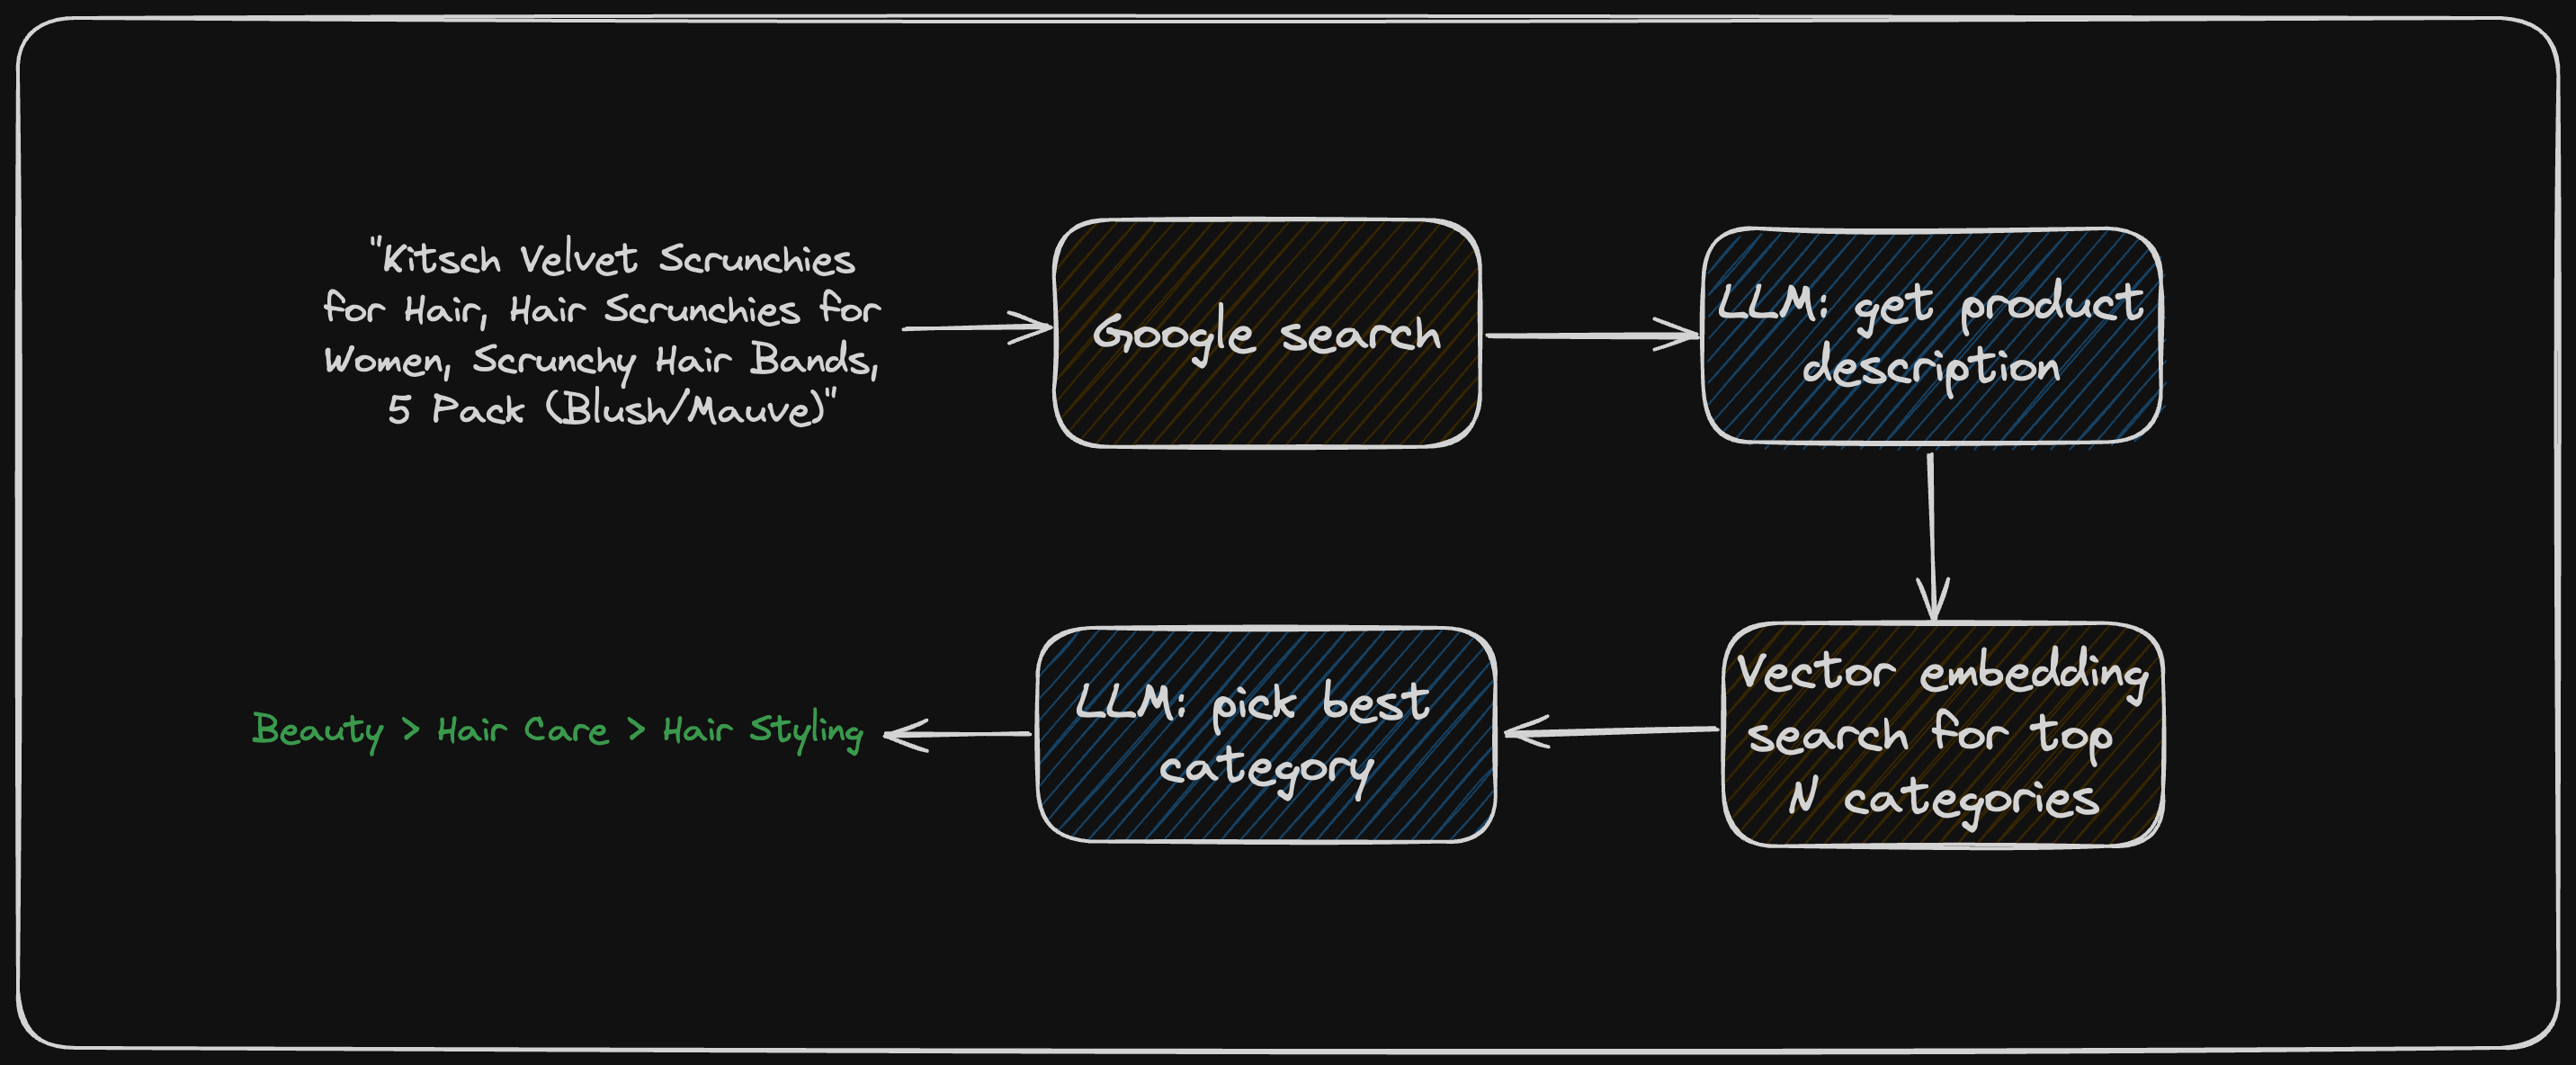

In [5]:
from IPython.display import Image
Image("image.png")

Install dependencies, import libraries, and load the data and the taxonomy

In [1]:
# %pip install cohere

import json
import pandas as pd
from superpipe import *
from pydantic import BaseModel, Field
import cohere
import os
import numpy as np
from typing import List

/var/folders/bh/hwln9nhn6tb990j17wgs638r0000gn/T/ipykernel_89835/1194329160.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
taxonomy = pd.read_csv('./taxonomy.csv').fillna("")
taxonomy = list(taxonomy['sector'] + " > " + taxonomy['department'] + " > " + taxonomy['major_category'])
df = pd.read_csv('./data.csv')

### Defining the Pipeline using Superpipe

Now, let's define the first step of the pipeline which uses a Google SERP library to search for the `description` field on the input object.

We do this by using Superpipe's built-in `SERPEnrichmentStep`. You could also easily build your own using a `CustomStep` instead.

In [3]:
def shorten(serp_result):
  top_n = 5
  short = []
  y = json.loads(serp_result).get('organic')
  if y is None:
    return None
  for o in y[:top_n]:
    short.append({
        'title': o['title'],
        'snippet': o['snippet'],
        'link': o['link']
    })
  return short

serp_step = steps.SERPEnrichmentStep(
  prompt=lambda row: row['description'], 
  postprocess=shorten,
  name="serp")

The second step of the pipeline takes the product description and the search results and feeds them into an LLM to get a better description. We create this step using `LLMStructuredStep`.

An `LLMStructuredStep` instance takes a Pydantic model and a prompt generator function as arguments. The pydantic model specifies the output structure (remember every `LLMStructuredStep` creates structured output). The prompt generator function defines how to generate a prompt from the input data.

In [4]:
short_description_prompt = lambda row: f"""
You are given a product description and a list of google search results about a product.
Return a single sentence decribing the product.
Product description: {row['description']}
Search results:
{row['serp']}
"""

class ShortDescription(BaseModel):
  short_description: str = Field(description="A single sentence describing the product")
  
short_description_step = steps.LLMStructuredStep(
  prompt=short_description_prompt,
  model=models.gpt35,
  out_schema=ShortDescription,
  name="short_description"
)

Next we define the embedding classification step which creates a vector embedding from the taxonomy, and then finds the top 5 nearest neighbors for each input data point based on the short description generated in the previous step. 

We can use the built-in `EmbeddingSearchStep` and provide it an `embed` function. You can use any embedding provider here. We use Cohere in this example.

In [5]:
# set your cohere api key as an env var or set it directly here
COHERE_API_KEY = os.environ.get('COHERE_API_KEY')
co = cohere.Client(COHERE_API_KEY)

def embed(texts: List[str]):
  embeddings = co.embed(
    model="embed-english-v3.0",
    texts=texts,
    input_type='classification'
  ).embeddings
  return np.array(embeddings).astype('float32')

embedding_search_prompt = lambda row: row["short_description"]

embedding_search_step = steps.EmbeddingSearchStep(
  search_prompt= embedding_search_prompt,
  embed_fn=embed,
  k=5,    
  candidates=taxonomy,
  name="embedding_search"
)

Finally we take the top 5 categories selected by the embedding step, feed them into an LLM query and ask it to pick the index of the best one. We use an `LLMStructuredStep` for this.

In [6]:

def categorize_prompt(row):
    categories = ""
    i = 1
    while f"candidate{i}" in row["embedding_search"]:
        categories += f'{i}. {row["embedding_search"][f"candidate{i}"]}\n'
        i += 1

    return f"""
    You are given a product description and {i-1} options for the product's category.
    Pick the index of the most accurate category.
    The index must be between 1 and {i-1}.
    Product description: {row['short_description']}
    Categories:
    {categories}
    """
    
class CategoryIndex(BaseModel):
    category_index: int = Field(description="The index of the most accurate category")
    
categorize_step = steps.LLMStructuredStep(
  prompt=categorize_prompt,
  model=models.gpt35,
  out_schema=CategoryIndex,
  name="categorize"
)

The previous step output a category index but we want the actual category, so we need to map the index to the category. We'll create a simple `CustomStep` that simply grabs the `category{i}` field that was created in the embedding search step.

In [7]:
class Category(BaseModel):
    category: str = Field(description="The most accurate category")

select_category_step = steps.CustomStep(
  transform=lambda row: row["embedding_search"][f'candidate{row["category_index"]}'],
  out_schema=Category,
  name="category"
)

We're done defining the steps. Finally, we define an evaluation function - a simple string comparison against the ground truth column which was present in the dataset. Then we define a `Pipeline` and run it.

In [8]:
evaluate = lambda row: row['category'].lower() == row['gpt4_category'].lower()

categorizer = pipeline.Pipeline([
  serp_step, 
  short_description_step, 
  embedding_search_step, 
  categorize_step,
  select_category_step
], evaluate)

categorizer.run(df)

Running step serp...


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:05<00:00,  6.56s/it]


Running step short_description...


100%|██████████| 10/10 [00:35<00:00,  3.58s/it]


Running step embedding_search...
Running step categorize...


100%|██████████| 10/10 [00:22<00:00,  2.28s/it]


Running step select_category...


100%|██████████| 10/10 [00:00<00:00, 11259.88it/s]


,description,gpt4_category,serp,__short_description__,short_description,category1,category2,category3,category4,category5,__categorize__,category_index,category
0,Duracell Coppertop Alkaline Batteries AA - 48 pk,Household Essentials > Household Batteries > A...,[{'title': 'Duracell Coppertop Alkaline Batter...,"{'input_tokens': 646, 'output_tokens': 33, 'su...",Duracell Coppertop Alkaline Batteries AA in a ...,Household Essentials > Household Batteries > A...,Household Essentials > Household Batteries > A...,Household Essentials > Household Batteries > R...,Household Essentials > Household Batteries > S...,Automotive > Auto Parts > Car Batteries & Acce...,"{'input_tokens': 193, 'output_tokens': 10, 'su...",1,Household Essentials > Household Batteries > A...
1,"Kitsch Velvet Scrunchies for Hair, Hair Scrunc...",Beauty > Hair Care > Hair Styling,[{'title': 'Velvet Scrunchies - Blush/Mauve – ...,"{'input_tokens': 609, 'output_tokens': 32, 'su...",A pack of 5 Velvet Scrunchies in blush and mau...,Beauty > Hair Care > Hair Color,Beauty > Hair Care > Hair Styling,Beauty > Hair Care > Hair Brushes & Combs,Beauty > Hair Care >,Beauty > Hair Care > Hair Styling Tools,"{'input_tokens': 179, 'output_tokens': 10, 'su...",2,Beauty > Hair Care > Hair Styling
2,"Kellogg's Cold Breakfast Cereal, Bulk Pantry S...",Grocery > Breakfast > Cold Cereal,"[{'title': 'Kellogg's Cold Breakfast Cereal, B...","{'input_tokens': 568, 'output_tokens': 38, 'su...",A variety pack of Kellogg's cold breakfast cer...,Grocery > Breakfast > Cold Cereal,Grocery > Frozen > Frozen Breakfast,Grocery > Breakfast > Oatmeal & Hot Cereal,Grocery > Breakfast >,Grocery > Snacks >,"{'input_tokens': 179, 'output_tokens': 10, 'su...",1,Grocery > Breakfast > Cold Cereal
3,Bar Keepers Friend Powdered Cleanser 12-Ounces...,Household Essentials > Household Cleaners > Me...,[{'title': 'Bar Keepers Friend Powdered Cleans...,"{'input_tokens': 595, 'output_tokens': 51, 'su...",Bar Keepers Friend Powdered Cleanser in a 12-O...,Household Essentials > Household Cleaners > Me...,Beauty > Bath & Body > Bar Soap,Household Essentials > Household Cleaners > Al...,Industrial > Janitorial & Sanitation Supplies ...,Beauty > Skin Care > Skin Cleansers,"{'input_tokens': 212, 'output_tokens': 10, 'su...",1,Household Essentials > Household Cleaners > Me...
4,"Orgain Organic Kids Nutritional Protein Shake,...",Baby > Baby Food & Nutrition > Baby Drinks,[{'title': 'Orgain Organic Kids Nutritional Pr...,"{'input_tokens': 676, 'output_tokens': 64, 'su...",Orgain Organic Kids Nutritional Protein Shake ...,Health & Medicine > Vitamins & Supplements > C...,Health & Medicine > Fitness & Weight Loss > Pr...,Baby > Baby Food & Nutrition >,Health & Medicine > Fitness & Weight Loss > Pr...,Baby > Baby Food & Nutrition > Baby Food,"{'input_tokens': 226, 'output_tokens': 10, 'su...",1,Health & Medicine > Vitamins & Supplements > C...
5,Crosley Furniture Everett Mid-Century Modern M...,Home > Furniture > TV Stands & Entertainment C...,[{'title': 'Crosley Furniture Everett Mid-Cent...,"{'input_tokens': 531, 'output_tokens': 48, 'su...",The Crosley Furniture Everett Mid-Century Mode...,"Home > Furniture > Accent, Coffee, & Console T...",Home > Furniture >,Home > Furniture > TV Stands & Entertainment C...,Electronics > Home Audio > Stereo Shelf Systems,Home > Furniture > Entertaining Furniture,"{'input_tokens': 197, 'output_tokens': 10, 'su...",3,Home > Furniture > TV Stands & Entertainment C...
6,"Dorco Tinkle Eyebrow Razors for Women, Dermapl...",Personal Care > Shaving & Grooming > Women's S...,[{'title': 'Dorco Tinkle Eyebrow Razors for Wo...,"{'input_tokens': 711, 'output_tokens': 54, 'su...",Dorco Tinkle Eyebrow Razors for Women is a der...,Personal Care > Shaving & Grooming > Women's S...,Personal Care > Shaving & Grooming >,Beauty > Skin Care > Skin Care Tools,Beauty > Cosmetics > Makeup Tools & Brushes,Beauty > Hair Care >,"{'input_tokens': 208, 'output_tokens': 10, 'su...",3,Beauty > Skin Care > Skin Care T

### Evaluating accuracy, token usage and latency

Superpipe makes it easy to:

- Evaluate the accuracy of your pipeline if your dataset has a ground truth column. If you passed in an `evaluate` function you can call `Pipeline.score` to get the accuracy score
- Track the token usage and latency for each row or in aggregate over the entire dataset. To get the aggregate statistics, call `Pipeline.statistics`

In [9]:
print(f"Accuracy: {categorizer.score}")
print(f"Statistics: {categorizer.statistics}")

Accuracy: 0.7
Statistics: {
    "input_tokens": {
        "gpt-3.5-turbo-0125": 8143
    },
    "output_tokens": {
        "gpt-3.5-turbo-0125": 556
    },
    "num_success": 10,
    "num_failure": 0,
    "total_latency": 58.50821637362242
}


### Tuning the pipeline

In [10]:
categorizer.update_params({
  "categorize": {
    "model": models.gpt4
  }
})
categorizer.run(df)
print(f"Accuracy: {categorizer.score}")
print(f"Statistics: {categorizer.statistics}")

Running step serp...


100%|██████████| 10/10 [00:48<00:00,  4.87s/it]


Running step short_description...


100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


Running step embedding_search...
Running step categorize...


100%|██████████| 10/10 [00:31<00:00,  3.18s/it]


Running step select_category...


100%|██████████| 10/10 [00:00<00:00, 12394.52it/s]

Accuracy: 0.9
Statistics: {
    "input_tokens": {
        "gpt-3.5-turbo-0125": 6073,
        "gpt-4-turbo-preview": 2011
    },
    "output_tokens": {
        "gpt-3.5-turbo-0125": 460,
        "gpt-4-turbo-preview": 100
    },
    "num_success": 10,
    "num_failure": 0,
    "total_latency": 56.871944959741086
}


### Running a grid search over parameters

First we define the "grid", ie. a list of values for each parameter that we want to try out. The grid must be defined as a dictionary of dictionaries where the top-level key is the name of the step and the second-level key is the name of the parameter

The `"global"` top-level key is special: parameters defined under `"global"` will be applied to all steps. If a step doesn't use that param, it will simply be ignored. If the same parameter is defined under global as well as under the step name, the value under the step name will take precedence.

In the below example, `params_grid['global']['model']` will be used by the `categorize` step since no overriding model is specified, but ignored by the `short_description` step because the `model` key is overriden.

The grid defined below will run 2 * 2 * 2 = 8 configurations.

In [11]:
params_grid = {
  "global": {
    "model": [models.gpt35, models.gpt4]
  },
  serp_step.name: {
    "top_n": [3, 5]
  },
  short_description_step.name: {
    "model": [models.gpt35]
  },
  embedding_search_step.name: {
    "k": [5, 10],
  }
}

In [12]:
from superpipe import grid_search

search = grid_search.GridSearch(categorizer, params_grid)
search.run(df)

Iteration 1 of 8
Params:  {'global': {'model': 'gpt-3.5-turbo-0125'}, 'serp': {'top_n': 3}, 'short_description': {'model': 'gpt-3.5-turbo-0125'}, 'embedding_search': {'k': 5}}
Result:  {'global__model': 'gpt-3.5-turbo-0125', 'serp__top_n': 3, 'short_description__model': 'gpt-3.5-turbo-0125', 'embedding_search__k': 5, 'score': 0.6, 'input_tokens': defaultdict(<class 'int'>, {'gpt-3.5-turbo-0125': 8118}), 'output_tokens': defaultdict(<class 'int'>, {'gpt-3.5-turbo-0125': 541}), 'num_success': 10, 'num_failure': 0, 'total_latency': 49.89761724695563, 'index': -140950531981795240}
Iteration 2 of 8
Params:  {'global': {'model': 'gpt-3.5-turbo-0125'}, 'serp': {'top_n': 3}, 'short_description': {'model': 'gpt-3.5-turbo-0125'}, 'embedding_search': {'k': 10}}
Result:  {'global__model': 'gpt-3.5-turbo-0125', 'serp__top_n': 3, 'short_description__model': 'gpt-3.5-turbo-0125', 'embedding_search__k': 10, 'score': 0.6, 'input_tokens': defaultdict(<class 'int'>, {'gpt-3.5-turbo-0125': 8751}), 'output

,global__model,serp__top_n,short_description__model,embedding_search__k,score,input_tokens,output_tokens,num_success,num_failure,total_latency,index
0,gpt-3.5-turbo-0125,3,gpt-3.5-turbo-0125,5,0.6,{'gpt-3.5-turbo-0125': 8118},{'gpt-3.5-turbo-0125': 541},10,0,49.897617,-140950531981795240
1,gpt-3.5-turbo-0125,3,gpt-3.5-turbo-0125,10,0.6,{'gpt-3.5-turbo-0125': 8751},{'gpt-3.5-turbo-0125': 572},10,0,37.869930,-5214020317066003945
2,gpt-3.5-turbo-0125,5,gpt-3.5-turbo-0125,5,0.8,{'gpt-3.5-turbo-0125': 8179},{'gpt-3.5-turbo-0125': 589},10,0,88.111890,408154170496236326
3,gpt-3.5-turbo-0125,5,gpt-3.5-turbo-0125,10,0.5,{'gpt-3.5-turbo-0125': 8730},{'gpt-3.5-turbo-0125': 563},10,0,172.641982,5329708189983242092
4,gpt-4-turbo-preview,3,gpt-3.5-turbo-0125,5,0.9,"{'gpt-3.5-turbo-0125': 6097, 'gpt-4-turbo-prev...","{'gpt-3.5-turbo-0125': 458, 'gpt-4-turbo-previ...",10,0,45.846981,7300372654060448865
5,gpt-4-turbo-preview,3,gpt-3.5-turbo-0125,10,0.8,"{'gpt-3.5-turbo-0125': 6099, 'gpt-4-turbo-prev...","{'gpt-3.5-turbo-0125': 473, 'gpt-4-turbo-previ...",10,0,50.523085,2027969551187248201
6,gpt-4-turbo-preview,5,gpt-3.5-turbo-0125,5,0.6,"{'gpt-3.5-turbo-0125': 6201, 'gpt-4-turbo-prev...","{'gpt-3.5-turbo-0125': 455, 'gpt-4-turbo-previ...",10,0,48.812741,3547485497719024256
7,gpt-4-turbo-preview,5,gpt-3.5-turbo-0125,10,0.8,"{'gpt-3.5-turbo-0125': 6108, 'gpt-4-turbo-prev...","{'gpt-3.5-turbo-0125': 474, 'gpt-4-turbo-previ...",10,0,54.173871,-5348831425406814354


In [ ]:
# Print the best score and params
print(f"Best score: {search.best_score}")
print(f"Best params: {search.best_params}")

# Pick the best params and re-run the pipeline
categorizer.update_params(search.best_params)
categorizer.run(df)